<a href="https://colab.research.google.com/github/TomGermeau/BlancPain/blob/main/code/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Detecting the difficulty level of French texts**

## Installing and loading packages

In [1]:
# Install and update spaCy
!pip install -U spacy

# Download the english language model
!python -m spacy download fr_core_news_sm


     |████████████████████████████████| 6.0 MB 9.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 181 kB 63.0 MB/s 
     |████████████████████████████████| 628 kB 37.2 MB/s 
     |████████████████████████████████| 451 kB 41.3 MB/s 
     |████████████████████████████████| 10.1 MB 21.5 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 17.4 M

In [2]:
# Import required packages
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import numpy as np
from google.colab import files
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import gensim
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from pandas.core.internals.construction import to_arrays
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns


## 1. Data preparation 

Firts we load the training dataset from Github in our notebook and show the first 5 lines.

In [3]:
# read in training data
df = pd.read_csv("https://raw.githubusercontent.com/TomGermeau/BlancPain/main/data/training_data.csv")
df.head()


,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


Then we print information about a train data including the index dtype and columns, non-null values and memory usage to get more information about the data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4800 non-null   int64 
 1   sentence    4800 non-null   object
 2   difficulty  4800 non-null   object
dtypes: int64(1), object(2)
memory usage: 112.6+ KB


We also load the unlablled data form Github on which we have to make predictions.

In [5]:
# read in the test data
df_pred = pd.read_csv("https://raw.githubusercontent.com/TomGermeau/BlancPain/main/data/unlabelled_test_data.csv")
df_pred.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


### 1.1. Baseline
The base line shows us the accurancy of the model if it just predicts for all cases the most frequent label.
Therfore we first have to look on the frequencies of all our labels in our dataset. We can also see that the training data is balanced because the percentege of the occurance of the different classes are mostly the same.

In [6]:
percenteges= df.difficulty.value_counts(normalize=True)
percenteges

A1    0.169375
C2    0.168125
C1    0.166250
A2    0.165625
B1    0.165625
B2    0.165000
Name: difficulty, dtype: float64

The maximum of all these percenteges is the baseline of the training data, the accurancy of our model has definitly to be above to be better than a random prediction.

In [7]:
baseline = max(percenteges)
baseline

0.169375

### 1.2 Data Split
First we searate the features from the labels and we make a 80/20 split into train and test data to evaluate our model on data that it has not seen before.

In [8]:
X = df['sentence'] # the features we want to analyze
ylabels = df['difficulty'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=0)

X_train

70                                Comment t'appelles-tu ?
4347    Voilà qui serait en effet de nature à simplifi...
1122    Les pèlerins partagèrent alors cette célébrati...
4570                          Qu'est-ce que vous faites ?
34      En voici un des moins obscurs : "Plus nous dev...
                              ...                        
1033    Les micro-changements apportés par ce type d'u...
3264    J'allais à la poste quand j'ai croisé ma cousi...
1653    Au cours des années 1970 et 1980, plusieurs gr...
2607    Stop : tout d'abord, figurez-vous que les vrai...
2732    "On s'est alors dit que le terrain commençait ...
Name: sentence, Length: 3840, dtype: object

### 1.3 Evaluation Function

This function we will use for evaluating all our models.

In [9]:
def evaluate(test, pred):
    precision = precision_score(test, pred, 
                                           pos_label='positive',
                                           average='macro')
    recall = recall_score(test, pred, 
                                           pos_label='positive',
                                           average='macro')
    f1 = f1_score(test, pred, average='macro')
    cm = confusion_matrix(test, pred)
    cm = sns.heatmap(cm, annot=True)
    print(cm)
    print(f"CONFUSION MATRIX:\n{confusion_matrix(test, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(test, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

### 1.4. Function for selecting wrong predictions

In [10]:
def wrong_sentences(test, pred):
  act_pred = pd.DataFrame()
  act_pred["actual"] = test
  act_pred["predicted"] = pred
  act_pred["example"] = df['sentence']
  incorrect = act_pred[act_pred["actual"] != act_pred["predicted"]]
  return incorrect


## 2. Train models without data cleaning

### 2.1 Logistic Regression (without data cleaning)

In [ ]:
# Define vectorizer for creating a column for each word of the sentence
vectorizer = TfidfVectorizer() 

# Define classifier
classifier = LogisticRegression()


# Create pipeline
pipe = Pipeline([('vectorizer', vectorizer),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [ ]:
#predict y_test
pred_LR = pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[93 31 21 10  4  2]
 [54 60 30  6  6  8]
 [12 38 64 17  9 20]
 [ 6  6 15 66 27 24]
 [ 4  4 10 37 73 45]
 [ 7  8  8 19 24 92]]
ACCURACY SCORE:
0.4667
CLASSIFICATION REPORT:
	Precision: 0.4645
	Recall: 0.4677
	F1_Score: 0.4640


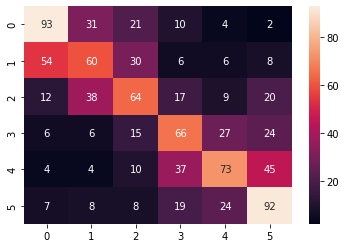

In [ ]:
#print confusion matrix, accurancy score, precision, recore and F1_score
evaluate(y_test, pred_LR)

We can see that by training our model with the Logistic Regression without any data cleaning and optimization we predict 46.67 % of the test samples correct.

Let us now have a look at some exmples of wrong predictions:

In [ ]:
#few examples of sentences that are not well classified
wrong=wrong_sentences(y_test, pred_LR)
wrong.head(10)

,actual,predicted,example
2255,C1,C2,"C'est en décembre 1967, après bien des invecti..."
608,C1,B2,Giscard va pourtant réussir à transformer ce r...
2856,A2,B1,Un choix difficile mais important : le public ...
1889,B1,C1,Le débat porte plutôt sur l'utilité d'une tell...
2358,A2,B1,Il faut du temps et du courage pour soigner to...
2250,C1,C2,"Vous eussiez juré que les gens la voyaient, l'..."
3325,A1,A2,"Mon frère Patrice est plus jeune que moi, il v..."
4363,C1,B2,Le risque de plagiat?
4763,B1,A2,Je vous souhaite bonne année pleine de bonheur...
979,B1,C2,"Le visage comprend une oreille de chaque côté,..."


We can see that there are also examples with numbers and punctuation. This could indicate that data cleaning will help us.

### 2.1 KNN ( without data cleaning )

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
# Define classifier
knn = KNeighborsClassifier()

# Create pipeline
pipe_knn = Pipeline([('vectorizer', vectorizer),
                 ('knn', knn)])

# Fit model on training set
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('knn', KNeighborsClassifier())])

In [ ]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#predict y_test
pred_knn = pipe_knn.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[121  28   8   1   1   2]
 [ 98  51  12   1   1   1]
 [ 81  39  33   3   1   3]
 [ 49  30  19  29   3  14]
 [ 48  36  29  15  29  16]
 [ 37  29  17  23   9  43]]
ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
	Precision: 0.4007
	Recall: 0.3183
	F1_Score: 0.3022


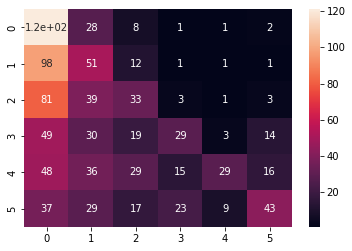

In [ ]:
#print confusion matrix, accurancy score, precision, recore and F1_score
evaluate(y_test, pred_knn)

We will now try to improve our knn model with hyperparameters tuning


In [ ]:
from sklearn.model_selection import ParameterGrid
grid_knn={'n_neighbors':np.arange(1,100,5), 'p':[1,2], 'weights':['uniform','distance']}

In [ ]:
knn_cv=GridSearchCV(knn, grid_knn, cv=5)
pipe_knni = Pipeline([('vectorizer', vectorizer),
                 ('knn',knn_cv)])

pipe_knni.fit(X_train, y_train)

print('Hypepareameters:' , knn_cv.best_params_)


Hypepareameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


In [ ]:
pred_knni=pipe_knni.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[114  30  12   2   0   3]
 [ 91  56  14   0   1   2]
 [ 69  43  39   4   2   3]
 [ 40  25  20  37   7  15]
 [ 29  32  23  23  35  31]
 [ 32  27  17  15   8  59]]
ACCURACY SCORE:
0.3542
CLASSIFICATION REPORT:
	Precision: 0.4197
	Recall: 0.3543
	F1_Score: 0.3450


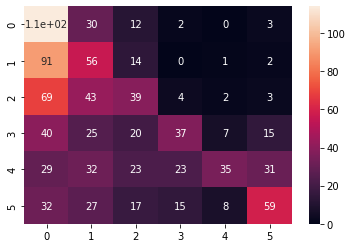

In [ ]:
evaluate(y_test,pred_knni)

### 2.3 Decision Tree ( without data cleaning )

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
pipe_dt=Pipeline([('vectorizer', vectorizer),
                  ('dt', dt)])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[82 38 22  9  4  6]
 [49 52 32 21  4  6]
 [30 41 38 19 19 13]
 [ 8 18 30 42 27 19]
 [10 23 32 40 40 28]
 [12 16 28 31 32 39]]
ACCURACY SCORE:
0.3052
CLASSIFICATION REPORT:
	Precision: 0.3071
	Recall: 0.3056
	F1_Score: 0.3026


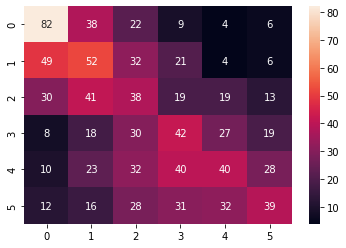

In [ ]:
pipe_dt.fit(X_train, y_train)
pred_dt=pipe_dt.predict(X_test)
evaluate(y_test, pred_dt)

We will now try to improve the parameter max_depth

In [ ]:
grid_dt={'max_depth': np.arange(1,2000,50 )}#here i tried different values of max_depth and then reduce the scale of values to reduce the execution time
dt_cv=GridSearchCV(dt, grid_dt, cv=10)
pipe_dti=Pipeline([('vectorizer', vectorizer),
                   ('dt_cv', dt_cv)])

pipe_dti.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('dt_cv',
                 GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                              param_grid={'max_depth': array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
       1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501, 1551, 1601,
       1651, 1701, 1751, 1801, 1851, 1901, 1951])}))])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[81 39 24  9  2  6]
 [52 53 34 15  3  7]
 [28 40 40 19 15 18]
 [ 8 23 27 39 27 20]
 [11 22 32 34 40 34]
 [11 13 24 33 36 41]]
ACCURACY SCORE:
0.3063
CLASSIFICATION REPORT:
	Precision: 0.3061
	Recall: 0.3063
	F1_Score: 0.3032


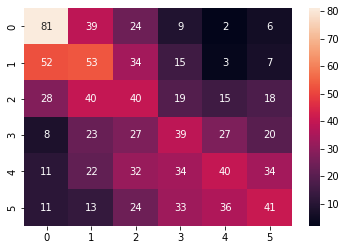

In [ ]:
pred_dti=pipe_dti.predict(X_test)
evaluate(y_test, pred_dti)

In [ ]:
dt_cv.best_params_

{'max_depth': 151}

### 2.4. Random Forest (without data cleaning)

In [ ]:
# Define classifier
classifierRF = RandomForestClassifier()

# Create pipeline
pipeRF = Pipeline([('vectorizer', vectorizer),
                 ('classifier', classifierRF)])

# Fit model on training set
pipeRF.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [ ]:
#predict y_test
pred_RF = pipeRF.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[126  19   6   7   2   1]
 [ 83  48  25   5   3   0]
 [ 38  41  51  16   4  10]
 [ 15  12  14  70  21  12]
 [ 17  11  19  52  50  24]
 [ 20  12   9  36  17  64]]
ACCURACY SCORE:
0.4260
CLASSIFICATION REPORT:
	Precision: 0.4395
	Recall: 0.4290
	F1_Score: 0.4150


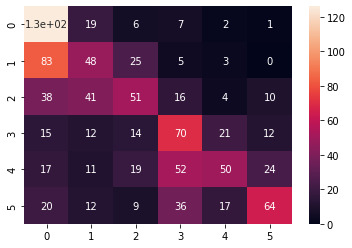

In [ ]:
#print confusion matrix, accurancy score, precision, recore and F1_score
evaluate(y_test, pred_RF)

We can see that by training our model with the Random Forest Classifier without any data cleaning and optimization we predict 40.42 % of the test samples correct.

Let us now have a look at some exmples of wrong predictions:

In [ ]:
#few examples of sentences that are not well classified
wrong=wrong_sentences(y_test, pred_RF)
wrong.head(10)

,actual,predicted,example
608,C1,A1,Giscard va pourtant réussir à transformer ce r...
2856,A2,B2,Un choix difficile mais important : le public ...
1889,B1,A1,Le débat porte plutôt sur l'utilité d'une tell...
2250,C1,B2,"Vous eussiez juré que les gens la voyaient, l'..."
3325,A1,A2,"Mon frère Patrice est plus jeune que moi, il v..."
4363,C1,A1,Le risque de plagiat?
2263,B1,A1,Que voulez-vous ?
3294,B2,A2,Après avoir identifié les inconvénients de la ...
3206,A2,A1,Je ne sais pas ; pas beaucoup peut-être ; pas ...
2087,A1,A2,Je m'occupe de mes deux enfants quand ils rent...


We can see that some of the wrong predictions are the same than before in the Logistic Regression Model. Therfore also in this case there is an indication that data cleaning will help us to improve the accurancy of our model.

## 3. Data cleaning

Fist of all we creat lists with punctuation marks, numbers and stop words. 

In [15]:
# Create a list of punctuation marks and numbers
punctuations = string.punctuation
numbers = "0123456789"

In [16]:
# Creat a list with stop words form french language
stop_words = fr_stop
list(stop_words)[:10]

['onzième',
 'maintenant',
 'vers',
 'vôtres',
 'celles-ci',
 'attendu',
 'doit',
 'lès',
 'six',
 'diverses']

For the data cleaning we created 3 differnent versions.
The first vesion uses lemmatization and convert to lowercases.

In [17]:
sp = spacy.load('fr_core_news_sm')

# Create tokenizer function
def spacy_tokenizer(sentence):
     
   
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)
    

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # Return preprocessed list of tokens
    return mytokens

    

The second one additionally removes punctuations and numbers.

In [18]:
sp = spacy.load('fr_core_news_sm')

# Create tokenizer function
def spacy_tokenizer_2(sentence):
     
   
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)
    

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    

    # Remove stop words and punctuation
    #mytokens = [ word for word in mytokens if word not in numbers and word not in punctuations ]
    mytokens_2 = []
    for word in mytokens:
      for char in word:
        if (char in punctuations) or (char in numbers):
          word = word.replace(char, "")
      if word != "":
        mytokens_2.append(word)


   

    # Return preprocessed list of tokens
    return mytokens_2

    

And the third also removes stopwords.

In [ ]:
sp = spacy.load('fr_core_news_sm')

# Create tokenizer function
def spacy_tokenizer_3(sentence):
     
   
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)
    

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in numbers and word not in punctuations ]
    mytokens_2 = []
    for word in mytokens:
      for char in word:
        if (char in punctuations) or (char in numbers):
          word = word.replace(char, "")
      if word != "":
        mytokens_2.append(word)


   

    # Return preprocessed list of tokens
    return mytokens_2

    

## 4. Train models with data cleaning

### 4.1. Logistic Regression with data cleaning

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[101  33  17   4   4   2]
 [ 43  72  31  11   3   4]
 [ 12  34  76  20  10   8]
 [  7  11  18  62  24  22]
 [  7   6  15  42  68  35]
 [ 10   8  10  20  32  78]]
ACCURACY SCORE:
0.4760
CLASSIFICATION REPORT:
	Precision: 0.4752
	Recall: 0.4764
	F1_Score: 0.4745


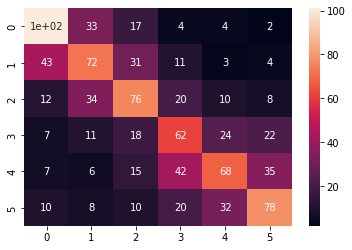

In [ ]:

# Define vectorizer
tfidf_vector_spacy = TfidfVectorizer(tokenizer=spacy_tokenizer) # we use the above defined tokenizer

# Define classifier

classifier = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)

# Create pipeline
pipeCL = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', classifier)])


# Fit model on training set
pipeCL.fit(X_train, y_train)

# Predictions
pred_CL1 = pipeCL.predict(X_test)

# Evaluation - test set
evaluate(y_test, pred_CL1)


Here we can see that by lemmatization and setting cases to lowers we improved the accurancy of the linear regression model with cross validation to 0.47.

In [ ]:
wrong=wrong_sentences(y_test, pred_CL1)
wrong.head(10)

,actual,predicted,example
2255,C1,C2,"C'est en décembre 1967, après bien des invecti..."
608,C1,A2,Giscard va pourtant réussir à transformer ce r...
1889,B1,B2,Le débat porte plutôt sur l'utilité d'une tell...
2250,C1,C2,"Vous eussiez juré que les gens la voyaient, l'..."
3325,A1,A2,"Mon frère Patrice est plus jeune que moi, il v..."
4363,C1,A1,Le risque de plagiat?
4763,B1,A2,Je vous souhaite bonne année pleine de bonheur...
979,B1,C2,"Le visage comprend une oreille de chaque côté,..."
2263,B1,A2,Que voulez-vous ?
3206,A2,A1,Je ne sais pas ; pas beaucoup peut-être ; pas ...


The wrong sentences are still mostly the same than in the models before.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[94 37 16  5  6  3]
 [50 61 30 12  7  4]
 [11 31 73 15 15 15]
 [ 8 12 19 56 24 25]
 [ 7  6 12 40 70 38]
 [10  7 10 18 31 82]]
ACCURACY SCORE:
0.4542
CLASSIFICATION REPORT:
	Precision: 0.4511
	Recall: 0.4541
	F1_Score: 0.4519


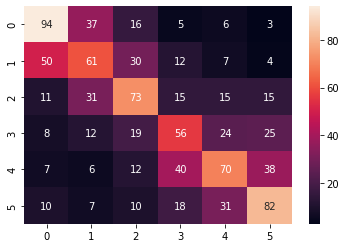

In [ ]:
# Define vectorizer
tfidf_vectorspacy_2 = TfidfVectorizer(tokenizer=spacy_tokenizer_2) # we use the above defined tokenizer_2

# Define classifier

classifier = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)

# Create pipeline
pipeCL = Pipeline([('vectorizer', tfidf_vectorspacy_2),
                 ('classifier', classifier)])


# Fit model on training set
pipeCL.fit(X_train, y_train)

# Predictions
pred_CL = pipeCL.predict(X_test)

# Evaluation - test set
evaluate(y_test, pred_CL)

If we also remove stopwords, numbers and punctuations the accurancy is lower than if we keep them form training our model.

And if we have a look on the sentence which are not predicted correct we can see that the sentence wiht numbers and punctuations are still predicted wrong.

In [ ]:
wrong=wrong_sentences(y_test, pred_CL)
wrong.head(10)

,actual,predicted,example
2255,C1,C2,"C'est en décembre 1967, après bien des invecti..."
608,C1,A2,Giscard va pourtant réussir à transformer ce r...
2856,A2,B2,Un choix difficile mais important : le public ...
1889,B1,C1,Le débat porte plutôt sur l'utilité d'une tell...
2250,C1,C2,"Vous eussiez juré que les gens la voyaient, l'..."
3325,A1,A2,"Mon frère Patrice est plus jeune que moi, il v..."
4363,C1,B2,Le risque de plagiat?
4763,B1,A2,Je vous souhaite bonne année pleine de bonheur...
979,B1,C2,"Le visage comprend une oreille de chaque côté,..."
2263,B1,A2,Que voulez-vous ?


## 4.2 KNN with data cleaning

In [ ]:

# Define classifier with optimal parameters
knn = KNeighborsClassifier(n_neighbors=9, p=2, weights='distance')

# Create pipeline
pipe_knn = Pipeline([('vectorizer', tfidf_vectorspacy_2),
                 ('knn', knn)])

# Fit model on training set
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer_2 at 0x7fb24eb7b440>)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=9, weights='distance'))])

In [ ]:
#predict y_test
pred_knn = pipe_knn.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[111  33  14   0   1   2]
 [ 83  58  18   3   1   1]
 [ 63  39  48   4   4   2]
 [ 29  28  21  35  12  19]
 [ 31  26  29  25  32  30]
 [ 34  27   8   5   8  76]]
ACCURACY SCORE:
0.3750
CLASSIFICATION REPORT:
	Precision: 0.4269
	Recall: 0.3754
	F1_Score: 0.3657


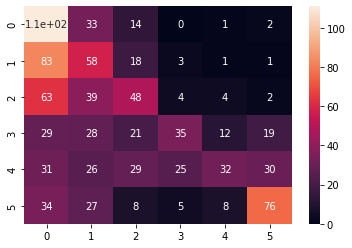

In [ ]:
#print confusion matrix, accurancy score, precision, recore and F1_score
evaluate(y_test, pred_knn)

##4.3 Decision Tree with data cleaning

In [ ]:
dt=DecisionTreeClassifier(max_depth=801)
pipe_dt=Pipeline([('vectorizer', vectorizer),
                  ('dt', dt)])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[80 42 23  8  3  5]
 [47 58 30 20  3  6]
 [28 40 37 15 23 17]
 [10 19 28 40 28 19]
 [15 14 31 34 43 36]
 [10 16 29 36 29 38]]
ACCURACY SCORE:
0.3083
CLASSIFICATION REPORT:
	Precision: 0.3074
	Recall: 0.3081
	F1_Score: 0.3050


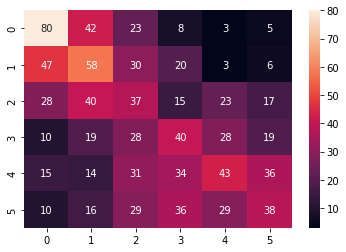

In [ ]:
pipe_dt.fit(X_train, y_train)
pred_dt=pipe_dt.predict(X_test)
evaluate(y_test, pred_dt)

 ### 4.4. Random Forest with data cleaning

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[113  27  14   5   1   1]
 [ 70  54  28   6   4   2]
 [ 24  34  58  27  10   7]
 [  8  18  23  51  31  13]
 [ 13  10  19  53  53  25]
 [ 12  13  18  25  31  59]]
ACCURACY SCORE:
0.4042
CLASSIFICATION REPORT:
	Precision: 0.4073
	Recall: 0.4046
	F1_Score: 0.3978


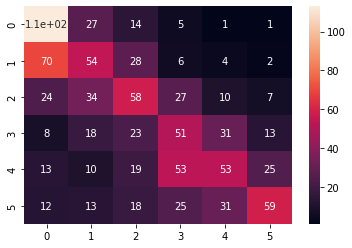

In [ ]:
# Define classifier

classifierRFC = RandomForestClassifier()

# Create pipeline
pipeRFC = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', classifierRFC)])


# Fit model on training set
pipeRFC.fit(X_train, y_train)

# Predictions
pred_RFC = pipeRFC.predict(X_test)

# Evaluation - test set
evaluate(y_test, pred_RFC)

Also for the Random Forest model the accurancy can be increased by using lemmnization and setting lower cases.

In [ ]:
wrong=wrong_sentences(y_test, pred_RFC)
wrong.head(10)

And the wrong classified sentences are again mostly the same.

In [ ]:
# Define classifier
tfidf_vector_sapcy_2 = TfidfVectorizer(tokenizer=spacy_tokenizer_2)
classifierRFC = RandomForestClassifier()

# Create pipeline
pipeRFC = Pipeline([('vectorizer', tfidf_vector_sapcy_2),
                 ('classifier', classifierRFC)])


# Fit model on training set
pipeRFC.fit(X_train, y_train)

# Predictions
pred_RFC = pipeRFC.predict(X_test)

# Evaluation - test set
evaluate(y_test, pred_RFC)

Also for the Random Forest model the accurancy  is lower when dropping stop words punctations and numbers.

## 5. Parameter optimization

Now we also tried to improve the accurancy by optimization of the two models and the vectorizer.

### 5.1. Linear Regression with parameter optimization

In [ ]:
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,1), (1,2), (1, 3), (2, 2), (2, 3), (3, 3)]
    min_df = [1]
    max_df = [1.0]
    analyzer=['word', 'char']
    
    # Create config instances
    for n in ngram_range:
        for i in min_df:
            for j in max_df:
              for a in analyzer:
                    cfg = [n, i, j, a]
                    models.append(cfg)
    return models

configs = configs()
configs[:10]

[[(1, 1), 1, 1.0, 'word'],
 [(1, 1), 1, 1.0, 'char'],
 [(1, 2), 1, 1.0, 'word'],
 [(1, 2), 1, 1.0, 'char'],
 [(1, 3), 1, 1.0, 'word'],
 [(1, 3), 1, 1.0, 'char'],
 [(2, 2), 1, 1.0, 'word'],
 [(2, 2), 1, 1.0, 'char'],
 [(2, 3), 1, 1.0, 'word'],
 [(2, 3), 1, 1.0, 'char']]

CONFIG:  [(1, 1), 1, 1.0, 'word']
AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[103  28  17   7   4   2]
 [ 47  68  29  11   4   5]
 [ 12  29  74  25   9  11]
 [  9   9  17  63  26  20]
 [  8   4  15  39  70  37]
 [ 10   9   9  18  31  81]]
ACCURACY SCORE:
0.4781
CLASSIFICATION REPORT:
	Precision: 0.4765
	Recall: 0.4786
	F1_Score: 0.4758
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

CONFIG:  [(1, 1), 1, 1.0, 'char']
AxesSubplot(0.125,0.125;0.496x0.755)
CONFUSION MATRIX:
[[84 31 17 15  5  9]
 [42 60 35 10  6 11]
 [16 35 62 18 12 17]
 [ 6  6 11 42 42 37]
 [ 5  3 13 45 43 64]
 [ 5  4  8 27 34 80]]
ACCURACY SCORE:
0.3865
CLASSIFICATION REPORT:
	Precision: 0.3875
	Recall: 0.3869
	F1_Score: 0.3843
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'word']
AxesSubplot(0.125,0.125;0.3968x0.755)
CONFUSION MATRIX:
[[103  26  17   7   4   4]
 [ 43  69  32   8   3   9]
 [ 14  30  70  21   8  17]
 [ 10   7  16  49  29  33]
 [  6   5  14  20  69  59]
 [  6   9  10  11  20 102]]
ACCURACY SCORE:
0.4813
CLASSIFICATION REPORT:
	Precision: 0.4792
	Recall: 0.4804
	F1_Score: 0.4744
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

CONFIG:  [(1, 2), 1, 1.0, 'char']
AxesSubplot(0.125,0.125;0.31744x0.755)
CONFUSION MATRIX:
[[104  26  19   5   4   3]
 [ 49  68  32   7   1   7]
 [ 14  26  75  25   9  11]
 [  5   6   8  60  26  39]
 [  6   1  11  43  59  53]
 [  6   9   3  25  30  85]]
ACCURACY SCORE:
0.4698
CLASSIFICATION REPORT:
	Precision: 0.4704
	Recall: 0.4708
	F1_Score: 0.4666
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.253952x0.755)
CONFUSION MATRIX:
[[ 97  25  20   7   3   9]
 [ 41  67  34   6   4  12]
 [ 13  30  66  18  10  23]
 [  6   8  18  43  23  46]
 [  3   4  14  12  58  82]
 [  5   8  10  10  15 110]]
ACCURACY SCORE:
0.4594
CLASSIFICATION REPORT:
	Precision: 0.4697
	Recall: 0.4589
	F1_Score: 0.4511
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CONFIG:  [(1, 3), 1, 1.0, 'char']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.203162x0.755)
CONFUSION MATRIX:
[[107  28  17   5   4   0]
 [ 50  69  37   6   1   1]
 [ 18  35  73  21   8   5]
 [  4   8   6  62  30  34]
 [  6   3   9  43  67  45]
 [  6   7   1  29  27  88]]
ACCURACY SCORE:
0.4854
CLASSIFICATION REPORT:
	Precision: 0.4837
	Recall: 0.4861
	F1_Score: 0.4822
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.162529x0.755)
CONFUSION MATRIX:
[[89 30 20 13  4  5]
 [44 62 38  8  4  8]
 [21 32 56 16 14 21]
 [ 8 17 11 48 32 28]
 [ 3 11 15 25 59 60]
 [ 3 10 13 16 25 91]]
ACCURACY SCORE:
0.4219
CLASSIFICATION REPORT:
	Precision: 0.4190
	Recall: 0.4219
	F1_Score: 0.4175
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos

CONFIG:  [(2, 2), 1, 1.0, 'char']
AxesSubplot(0.125,0.125;0.130023x0.755)
CONFUSION MATRIX:
[[105  29  15   5   6   1]
 [ 50  66  32   8   2   6]
 [ 18  24  77  23   9   9]
 [  4   8  10  61  28  33]
 [  8   3  11  40  63  48]
 [  6  10   4  25  32  81]]
ACCURACY SCORE:
0.4719
CLASSIFICATION REPORT:
	Precision: 0.4699
	Recall: 0.4727
	F1_Score: 0.4688
-----------------------
CONFIG:  [(2, 3), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.104019x0.755)
CONFUSION MATRIX:
[[83 34 23 11  5  5]
 [39 67 33 10  5 10]
 [24 31 57 12 12 24]
 [ 8 16 11 45 31 33]
 [ 3 10 17 24 55 64]
 [ 2  9 12 16 27 92]]
ACCURACY SCORE:
0.4156
CLASSIFICATION REPORT:
	Precision: 0.4147
	Recall: 0.4155
	F1_Score: 0.4109
-----------------------
CONFIG:  [(2, 3), 1, 1.0, 'char']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.083215x0.755)
CONFUSION MATRIX:
[[110  28  16   4   3   0]
 [ 54  69  33   6   1   1]
 [ 19  30  75  24   8   4]
 [  5   8   8  62  32  29]
 [  8   4   6  45  64  46]
 [  6   8   2  30  26  86]]
ACCURACY SCORE:
0.4854
CLASSIFICATION REPORT:
	Precision: 0.4847
	Recall: 0.4863
	F1_Score: 0.4819
-----------------------
CONFIG:  [(3, 3), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.066572x0.755)
CONFUSION MATRIX:
[[68 27 25 36  2  3]
 [27 57 41 29  4  6]
 [26 25 54 31  6 18]
 [11 10 10 71 19 23]
 [ 4 12 20 54 43 40]
 [ 7  9 12 40 28 62]]
ACCURACY SCORE:
0.3698
CLASSIFICATION REPORT:
	Precision: 0.3862
	Recall: 0.3736
	F1_Score: 0.3702
-----------------------
CONFIG:  [(3, 3), 1, 1.0, 'char']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.0532576x0.755)
CONFUSION MATRIX:
[[105  29  17   6   4   0]
 [ 55  67  30   7   2   3]
 [ 20  34  72  21   8   5]
 [  4   9   8  67  29  27]
 [  5   7   8  41  71  41]
 [  8   7   2  26  31  84]]
ACCURACY SCORE:
0.4854
CLASSIFICATION REPORT:
	Precision: 0.4850
	Recall: 0.4863
	F1_Score: 0.4831
-----------------------


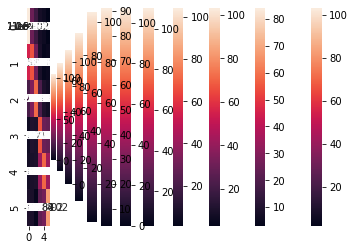

In [ ]:
# Define list for result
result = []

for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    classifier = LogisticRegression()

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

Here we can see that we get the best accurancy if we use the following parameter vor the vectorizer: 

*   gram_range = (1, 3)
*   min_df = 1
*   max_df = 1.0
*   analyzer="char"

In [ ]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()),('classifier' , LogisticRegression())])


# Create param grid.

param_grid = {
    'classifier__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'classifier__C' : [1, 4.281332398719396, 10, 100],
    'classifier__solver': ['liblinear', 'newton-cg', 'lbfgs'],

   
}

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fi

This are the best parameters for the Logistic Regression.

In [ ]:
best_clf.best_params_

{'classifier__C': 4,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

In [11]:
classifier = LogisticRegression(C=4.281332398719396, solver='liblinear', penalty='l2')

# Create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(C=4.281332398719396, solver='liblinear'))])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[95 35 18  8  2  3]
 [52 60 34  4  5  9]
 [13 35 72 14  7 19]
 [ 7  8 17 65 22 25]
 [ 5  5 15 40 64 44]
 [ 7  8  8 16 20 99]]
ACCURACY SCORE:
0.4740
CLASSIFICATION REPORT:
	Precision: 0.4733
	Recall: 0.4756
	F1_Score: 0.4704


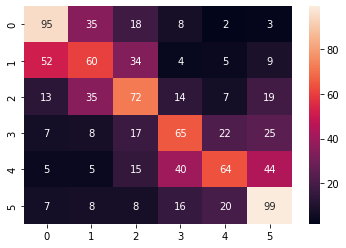

In [12]:
pred=pipe.predict(X_test)
# Evaluation - test set
evaluate(y_test, pred)

Now we train the Logistic Regression model again by using the best parameters for the vectorizer and the Logistic Regression.

In [ ]:
# Define classifier
classifier = LogisticRegression(C=4.281332398719396, solver='liblinear', penalty='l2')

# Create pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range = (1,2), min_df = 1, max_df = 1.0, analyzer='word')),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)
#instantiate the estimator
#LR = LogisticRegression()

# fit the estimator to our labelled data (input matrix and target vector)
#LR.fit(X_train, y_train)model = LogisticRegression(C=4.281332398719396, solver='liblinear')

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7fb24d964dd0>)),
                ('classifier',
                 LogisticRegression(C=4.281332398719396, solver='liblinear'))])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[ 99  31  18   8   2   3]
 [ 49  68  32   5   3   7]
 [ 16  33  78  14   8  11]
 [  6  11  15  59  24  29]
 [  5   7  12  24  68  57]
 [  5   9  10  12  22 100]]
ACCURACY SCORE:
0.4917
CLASSIFICATION REPORT:
	Precision: 0.4921
	Recall: 0.4921
	F1_Score: 0.4878


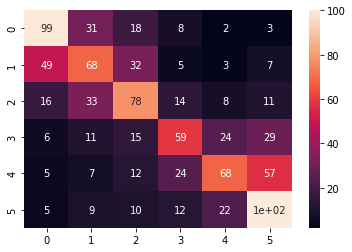

In [ ]:
pred=pipe.predict(X_test)
# Evaluation - test set
evaluate(y_test, pred)

Now we end up with the highest accurancy score of our model.

In [ ]:
sub_VT=pipe.predict(df_pred['sentence'])
df_sub_VT = pd.DataFrame()

df_sub_VT['difficulty']= sub_VT
df_sub_VT
df_sub_VT.to_csv("submission_VT.csv")
files.download("submission_VT.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 5.3. Random Forest with parameter optimization

CONFIG:  [(1, 1), 1, 1.0, 'word']
AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[117  23  10  10   0   1]
 [ 68  55  29   8   2   2]
 [ 32  32  50  30   9   7]
 [ 12   9  22  61  33   7]
 [ 13  11  15  62  46  26]
 [ 10  13  11  28  36  60]]
ACCURACY SCORE:
0.4052
CLASSIFICATION REPORT:
	Precision: 0.4113
	Recall: 0.4073
	F1_Score: 0.3975
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


CONFIG:  [(1, 1), 1, 1.0, 'char']
AxesSubplot(0.125,0.125;0.496x0.755)
CONFUSION MATRIX:
[[96 39 17  9  0  0]
 [50 64 35  8  1  6]
 [16 41 59 26  8 10]
 [ 4 10 22 49 33 26]
 [ 6  5 15 45 60 42]
 [ 7  8 10 33 33 67]]
ACCURACY SCORE:
0.4115
CLASSIFICATION REPORT:
	Precision: 0.4116
	Recall: 0.4111
	F1_Score: 0.4096
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


CONFIG:  [(1, 2), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.3968x0.755)
CONFUSION MATRIX:
[[127  19   8   7   0   0]
 [ 88  52  22   2   0   0]
 [ 45  34  54  17   6   4]
 [ 28  14  27  42  20  13]
 [ 31  12  23  46  37  24]
 [ 26   9  14  25  25  59]]
ACCURACY SCORE:
0.3865
CLASSIFICATION REPORT:
	Precision: 0.4028
	Recall: 0.3871
	F1_Score: 0.3721
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'char']
AxesSubplot(0.125,0.125;0.31744x0.755)
CONFUSION MATRIX:
[[108  28  18   4   3   0]
 [ 56  60  34  10   1   3]
 [ 15  34  58  31  10  12]
 [  6   9  12  59  37  21]
 [  7   3  17  45  66  35]
 [  5  11   7  29  47  59]]
ACCURACY SCORE:
0.4271
CLASSIFICATION REPORT:
	Precision: 0.4245
	Recall: 0.4273
	F1_Score: 0.4231
-----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


CONFIG:  [(1, 3), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.253952x0.755)
CONFUSION MATRIX:
[[141  15   2   3   0   0]
 [103  49  10   2   0   0]
 [ 70  34  40  11   3   2]
 [ 56  14  12  34  14  14]
 [ 49  21  15  32  36  20]
 [ 43  14   9  24  19  49]]
ACCURACY SCORE:
0.3635
CLASSIFICATION REPORT:
	Precision: 0.4150
	Recall: 0.3631
	F1_Score: 0.3433
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'char']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.203162x0.755)
CONFUSION MATRIX:
[[117  19  18   4   3   0]
 [ 60  60  33   8   2   1]
 [ 17  42  57  24   9  11]
 [  7  10   9  60  31  27]
 [  8   8  11  46  54  46]
 [  4  13  12  25  29  75]]
ACCURACY SCORE:
0.4406
CLASSIFICATION REPORT:
	Precision: 0.4335
	Recall: 0.4421
	F1_Score: 0.4336
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.162529x0.755)
CONFUSION MATRIX:
[[130  19   7   5   0   0]
 [ 90  47  20   7   0   0]
 [ 65  27  43  10  11   4]
 [ 53  14  11  40  14  12]
 [ 49  11  22  33  38  20]
 [ 40  10  17  23  29  39]]
ACCURACY SCORE:
0.3510
CLASSIFICATION REPORT:
	Precision: 0.3837
	Recall: 0.3512
	F1_Score: 0.3330
-----------------------
CONFIG:  [(2, 2), 1, 1.0, 'char']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.130023x0.755)
CONFUSION MATRIX:
[[110  30  13   5   1   2]
 [ 65  55  28  14   0   2]
 [ 21  34  52  33  10  10]
 [  7   7  21  46  35  28]
 [  8   7  18  39  61  40]
 [  5  12  12  24  36  69]]
ACCURACY SCORE:
0.4094
CLASSIFICATION REPORT:
	Precision: 0.4032
	Recall: 0.4087
	F1_Score: 0.4027
-----------------------
CONFIG:  [(2, 3), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.104019x0.755)
CONFUSION MATRIX:
[[134  17   5   1   2   2]
 [105  42  10   4   3   0]
 [ 75  26  32  11  11   5]
 [ 57  15   6  30  23  13]
 [ 58  10  21  19  41  24]
 [ 51   9   9  14  35  40]]
ACCURACY SCORE:
0.3323
CLASSIFICATION REPORT:
	Precision: 0.3717
	Recall: 0.3311
	F1_Score: 0.3104
-----------------------
CONFIG:  [(2, 3), 1, 1.0, 'char']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.083215x0.755)
CONFUSION MATRIX:
[[117  21  15   5   2   1]
 [ 62  50  37   9   2   4]
 [ 15  37  60  29  12   7]
 [  5   7  19  52  40  21]
 [  7   8  20  40  60  38]
 [  7  11   9  29  30  72]]
ACCURACY SCORE:
0.4281
CLASSIFICATION REPORT:
	Precision: 0.4215
	Recall: 0.4284
	F1_Score: 0.4214
-----------------------
CONFIG:  [(3, 3), 1, 1.0, 'word']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.066572x0.755)
CONFUSION MATRIX:
[[133  16   8   3   1   0]
 [114  37   7   2   3   1]
 [106  20  24   6   3   1]
 [ 99   9   6  17  10   3]
 [111   4  13   5  25  15]
 [ 97   6   8   7  19  21]]
ACCURACY SCORE:
0.2677
CLASSIFICATION REPORT:
	Precision: 0.3857
	Recall: 0.2662
	F1_Score: 0.2392
-----------------------
CONFIG:  [(3, 3), 1, 1.0, 'char']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.0532576x0.755)
CONFUSION MATRIX:
[[116  22  15   6   2   0]
 [ 68  50  31  11   3   1]
 [ 21  38  55  28  11   7]
 [  8   6  14  63  30  23]
 [  7   9  17  43  60  37]
 [  5  12  11  25  26  79]]
ACCURACY SCORE:
0.4406
CLASSIFICATION REPORT:
	Precision: 0.4358
	Recall: 0.4422
	F1_Score: 0.4336
-----------------------


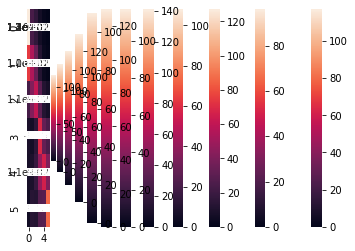

In [ ]:
for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    classifier = RandomForestClassifier()

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

Here we can see that we get the best accurancy if we use the following parameter vor the vectorizer: 

*   gram_range = (2, 2)
*   min_df = 1
*   max_df = 1.0
*   analyzer="char"

In [19]:


# Randomforest pipeline setup
rf_pipe = Pipeline([
 ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
 ('rf', RandomForestClassifier())])

# Fit
rf_pipe.fit(X_train, y_train)


# Setting up randomforest params
rf_params = {
 'rf__max_depth': [100, 50, 75],
 'rf__min_samples_split': [170, 160, 150],
 'rf__n_estimators' : list(range(10,101,10)),

}

KeyboardInterrupt: ignored

In [14]:
# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 5, verbose = 1, n_jobs = -1)


# Fitting Randomforest CV GS
rf_gs.fit(X_train, y_train)

NameError: ignored

The best parameter for our Random Forest model are:

In [ ]:
rf_gs.best_params_

In [20]:
# Define classifier
classifierRF = RandomForestClassifier(max_depth= 75, min_samples_split = 160)

# Create pipeline
pipeRF = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('classifier', classifierRF)])

# Fit model on training set
pipeRF.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(max_depth=75, min_samples_split=160))])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


AxesSubplot(0.125,0.125;0.62x0.755)
CONFUSION MATRIX:
[[119  16  16   6   3   1]
 [ 79  45  24   9   3   4]
 [ 27  33  54  16  10  20]
 [ 15   4  19  57  21  28]
 [ 13   7  15  43  47  48]
 [ 13  10  10  25  24  76]]
ACCURACY SCORE:
0.4146
CLASSIFICATION REPORT:
	Precision: 0.4100
	Recall: 0.4166
	F1_Score: 0.4018


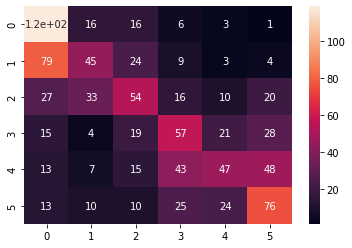

In [21]:
pred=pipeRF.predict(X_test)
# Evaluation - test set
evaluate(y_test, pred)

Now we train the Random Forest again by using the best parameters for the vectorizer and the Random Forest.

In [ ]:
# Define classifier
classifierRF = RandomForestClassifier(max_depth= 75, min_samples_split = 160)

# Create pipeline
pipeRF = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer, gram_range = (2, 2), min_df = 1, max_df = 1.0, analyzer='char')),
                 ('classifier', classifierRF)])

# Fit model on training set
pipeRF.fit(X_train, y_train)


In [ ]:
pred=pipeRF.predict(X_test)
# Evaluation - test set
evaluate(y_test, pred)

By the optimization of the parameters we could improve the accurancy of our model.

## 6. Word embedding

In [ ]:
w2v = gensim.models.Word2Vec(list(X_train), size=350, window=10, min_count=2, iter=20)

In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv.vocab]
    return np.mean(w2v[doc], axis=0)

In [ ]:
X['doc_vector'] = X.apply(document_vector)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(ylabels)


In [ ]:
X = list(X['doc_vector'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
clf = LogisticRegression(C=50)

In [ ]:
pred= clf.predict(X_test)

In [ ]:
evaluate(y_test, pred)

## 7. Video

And here is the video of for our project

In [22]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/VCCjqmJHalM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>